# Two implementations of heterodyne detection: direct heterodyne and as two homodyne measurements

Copyright (C) 2011 and later, Paul D. Nation & Robert J. Johansson

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp

In [3]:
import matplotlib.pyplot as plt

In [4]:
from qutip import *

## Introduction

Homodyne and hetrodyne detection are techniques for measuring the quadratures of a field using photocounters. Homodyne detection (on-resonant) measures one quadrature and with heterodyne detection (off-resonant) both quadratures can be detected simulateously.

The evolution of a quantum system that is coupled to a field that is monitored with homodyne and heterodyne detector can be described with stochastic master equations. This notebook compares two different ways to implement the heterodyne detection stochastic master equation in QuTiP.

## Deterministic reference

In [5]:
N = 15
w0 = 1.0 * 2 * np.pi
A = 0.1 * 2 * np.pi
times = np.linspace(0, 15, 301)
gamma = 0.25

ntraj = 150
nsubsteps = 50

a = destroy(N)
x = a + a.dag()
y = -1.0j*(a - a.dag())

H = w0 * a.dag() * a + A * (a + a.dag())

rho0 = coherent(N, np.sqrt(5.0), method='analytic')
c_ops = [np.sqrt(gamma) * a]
e_ops = [a.dag() * a, x, y]

In [6]:
result_ref = mesolve(H, rho0, times, c_ops, e_ops)

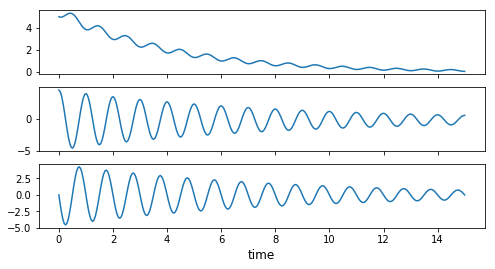

In [7]:
plot_expectation_values(result_ref);

## Heterodyne implementation #1

Stochastic master equation for heterodyne in Milburn's formulation

$\displaystyle d\rho(t) = -i[H, \rho(t)]dt + \gamma\mathcal{D}[a]\rho(t) dt + \frac{1}{\sqrt{2}} dW_1(t) \sqrt{\gamma} \mathcal{H}[a] \rho(t) + \frac{1}{\sqrt{2}} dW_2(t) \sqrt{\gamma} \mathcal{H}[-ia] \rho(t)$

where $\mathcal{D}$ is the standard Lindblad dissipator superoperator, and $\mathcal{H}$ is defined as above,
and $dW_i(t)$ is a normal distributed increment with $E[dW_i(t)] = \sqrt{dt}$.


In QuTiP format we have:

$\displaystyle d\rho(t) = -i[H, \rho(t)]dt +  D_{1}[A]\rho(t) dt + D_{2}^{(1)}[A]\rho(t) dW_1 + D_{2}^{(2)}[A]\rho(t) dW_2$

where $A = \sqrt{\gamma} a$, so we can identify

$\displaystyle D_{1}[A]\rho = \gamma \mathcal{D}[a]\rho = \mathcal{D}[A]\rho$

In [8]:
from qutip.expect import expect_rho_vec

In [9]:
L = liouvillian(H)
D = lindblad_dissipator(c_ops[0])
d1_operator = L + D
def d1_rho_func(t, rho_vec):
    return d1_operator * rho_vec

$D_{2}^{(1)}[A]\rho = \frac{1}{\sqrt{2}} \sqrt{\gamma} \mathcal{H}[a] \rho =
\frac{1}{\sqrt{2}} \mathcal{H}[A] \rho =
\frac{1}{\sqrt{2}}(A\rho + \rho A^\dagger - \mathrm{Tr}[A\rho + \rho A^\dagger] \rho)
\rightarrow \frac{1}{\sqrt{2}} \left\{(A_L +  A_R^\dagger)\rho_v - \mathrm{Tr}[(A_L +  A_R^\dagger)\rho_v] \rho_v\right\}$

$D_{2}^{(2)}[A]\rho = \frac{1}{\sqrt{2}} \sqrt{\gamma} \mathcal{H}[-ia] \rho 
= \frac{1}{\sqrt{2}} \mathcal{H}[-iA] \rho =
\frac{-i}{\sqrt{2}}(A\rho - \rho A^\dagger - \mathrm{Tr}[A\rho - \rho A^\dagger] \rho)
\rightarrow \frac{-i}{\sqrt{2}} \left\{(A_L -  A_R^\dagger)\rho_v - \mathrm{Tr}[(A_L - A_R^\dagger)\rho_v] \rho_v\right\}$

In [10]:
B1 = spre(c_ops[0]) + spost(c_ops[0].dag())
B2 = spre(c_ops[0]) + spost(c_ops[0].dag())
def d2_rho_func(t, rho_vec):
    e1 = expect_rho_vec(B1.data, rho_vec, False)
    drho1 = B1 * rho_vec - e1 * rho_vec

    e1 = expect_rho_vec(B2.data, rho_vec, False)
    drho2 = B2 * rho_vec - e1 * rho_vec

    return np.vstack([1.0/np.sqrt(2) * drho1, -1.0j/np.sqrt(2) * drho2])

The heterodyne currents for the $x$ and $y$ quadratures are

$J_x(t) = \sqrt{\gamma}\left<x\right> + \sqrt{2} \xi(t)$

$J_y(t) = \sqrt{\gamma}\left<y\right> + \sqrt{2} \xi(t)$

where $\xi(t) = \frac{dW}{dt}$.

In qutip we define these measurement operators using the `m_ops = [[x, y]]` and the coefficients to the noise terms `dW_factor = [sqrt(2/gamma), sqrt(2/gamma)]`.

In [11]:
result = general_stochastic(ket2dm(rho0), times, d1_rho_func, d2_rho_func, 
                  e_ops=[spre(op) for op in e_ops], 
                  len_d2=2, ntraj=ntraj, nsubsteps=nsubsteps*2, solver="platen",
                  dW_factors=[np.sqrt(2/gamma), np.sqrt(2/gamma)], 
                  m_ops=[spre(x), spre(y)],
                  store_measurement=True, map_func=parallel_map)

10.0%. Run time: 726.94s. Est. time left: 00:01:49:02
20.0%. Run time: 1177.90s. Est. time left: 00:01:18:31
30.0%. Run time: 1448.19s. Est. time left: 00:00:56:19
40.0%. Run time: 1744.10s. Est. time left: 00:00:43:36
50.0%. Run time: 2050.39s. Est. time left: 00:00:34:10
60.0%. Run time: 2446.47s. Est. time left: 00:00:27:10
70.0%. Run time: 3425.91s. Est. time left: 00:00:24:28
80.0%. Run time: 4123.43s. Est. time left: 00:00:17:10
90.0%. Run time: 4739.05s. Est. time left: 00:00:08:46
100.0%. Run time: 5331.43s. Est. time left: 00:00:00:00
Total run time: 5331.51s


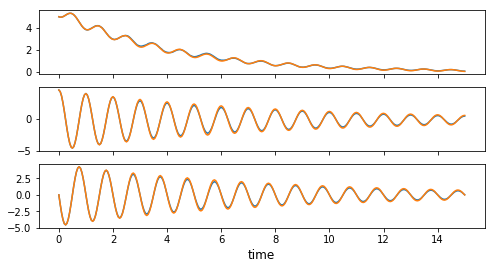

In [12]:
plot_expectation_values([result, result_ref]);

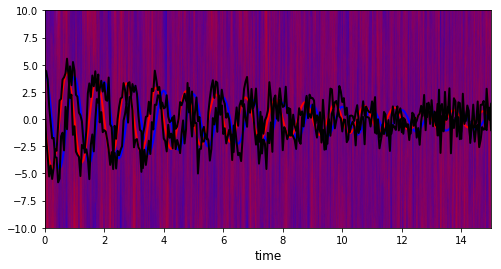

In [13]:
fig, ax = plt.subplots(figsize=(8,4))

for m in result.measurement:
    ax.plot(times, m[:, 0].real, 'b', alpha=0.05)
    ax.plot(times, m[:, 1].real, 'r', alpha=0.05)

ax.plot(times, result_ref.expect[1], 'b', lw=2);
ax.plot(times, result_ref.expect[2], 'r', lw=2);

ax.set_ylim(-10, 10)
ax.set_xlim(0, times.max())
ax.set_xlabel('time', fontsize=12)
ax.plot(times, np.array(result.measurement).mean(axis=0)[:,0].real, 'k', lw=2);
ax.plot(times, np.array(result.measurement).mean(axis=0)[:,1].real, 'k', lw=2);

## Heterodyne implementation #2: using two homodyne measurements


We can also write the heterodyne equation as

$\displaystyle d\rho(t) = -i[H, \rho(t)]dt + \frac{1}{2}\gamma\mathcal{D}[a]\rho(t) dt + \frac{1}{\sqrt{2}} dW_1(t) \sqrt{\gamma} \mathcal{H}[a] \rho(t) + \frac{1}{2}\gamma\mathcal{D}[a]\rho(t) dt + \frac{1}{\sqrt{2}} dW_2(t) \sqrt{\gamma} \mathcal{H}[-ia] \rho(t)$


And using the QuTiP format for two stochastic collapse operators, we have:

$\displaystyle d\rho(t) = -i[H, \rho(t)]dt + D_{1}[A_1]\rho(t) dt + D_{2}[A_1]\rho(t) dW_1 + D_{1}[A_2]\rho(t) dt + D_{2}[A_2]\rho(t) dW_2$

so we can also identify

$\displaystyle D_{1}[A_1]\rho = \frac{1}{2}\gamma \mathcal{D}[a]\rho = \mathcal{D}[\sqrt{\gamma}a/\sqrt{2}]\rho = \mathcal{D}[A_1]\rho$

$\displaystyle D_{1}[A_2]\rho = \frac{1}{2}\gamma \mathcal{D}[a]\rho = \mathcal{D}[-i\sqrt{\gamma}a/\sqrt{2}]\rho = \mathcal{D}[A_2]\rho$


$D_{2}[A_1]\rho = \frac{1}{\sqrt{2}} \sqrt{\gamma} \mathcal{H}[a] \rho = \mathcal{H}[A_1] \rho$

$D_{2}[A_2]\rho = \frac{1}{\sqrt{2}} \sqrt{\gamma} \mathcal{H}[-ia] \rho  = \mathcal{H}[A_2] \rho $

where $A_1 = \sqrt{\gamma} a / \sqrt{2}$ and $A_2 = -i \sqrt{\gamma} a / \sqrt{2}$.

In summary we have

$\displaystyle d\rho(t) = -i[H, \rho(t)]dt + \sum_i\left\{\mathcal{D}[A_i]\rho(t) dt + \mathcal{H}[A_i]\rho(t) dW_i\right\}$

which is a simultaneous homodyne detection with $A_1 = \sqrt{\gamma}a/\sqrt{2}$ and $A_2 = -i\sqrt{\gamma}a/\sqrt{2}$

Here the two heterodyne currents for the $x$ and $y$ quadratures are

$J_x(t) = \sqrt{\gamma/2}\left<x\right> + \xi(t)$

$J_y(t) = \sqrt{\gamma/2}\left<y\right> + \xi(t)$

where $\xi(t) = \frac{dW}{dt}$.

In qutip we can use the predefined homodyne solver for solving this problem.

In [14]:
opt = Options()
opt.store_states = True
result = smesolve(H, rho0, times, [], [np.sqrt(gamma/2) * a, -1.0j * np.sqrt(gamma/2) * a],
                  e_ops, ntraj=100, nsubsteps=nsubsteps, solver="taylor15",
                  m_ops=[x, y], dW_factors=[np.sqrt(2/gamma), np.sqrt(2/gamma)],
                  method='homodyne', store_measurement=True,
                  map_func=parallel_map)

10.0%. Run time:  66.22s. Est. time left: 00:00:09:55
20.0%. Run time: 131.95s. Est. time left: 00:00:08:47
30.0%. Run time: 195.57s. Est. time left: 00:00:07:36
40.0%. Run time: 257.92s. Est. time left: 00:00:06:26
50.0%. Run time: 324.28s. Est. time left: 00:00:05:24
60.0%. Run time: 393.51s. Est. time left: 00:00:04:22
70.0%. Run time: 465.37s. Est. time left: 00:00:03:19
80.0%. Run time: 533.48s. Est. time left: 00:00:02:13
90.0%. Run time: 597.27s. Est. time left: 00:00:01:06
100.0%. Run time: 672.84s. Est. time left: 00:00:00:00
Total run time: 672.92s


(<Figure size 576x288 with 3 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdeb0d370f0>],
       dtype=object))

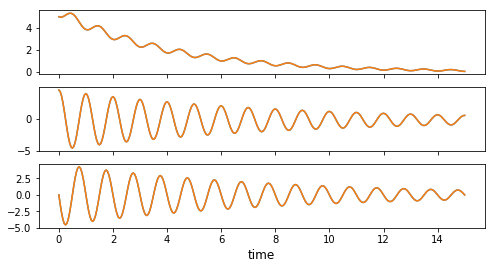

In [15]:
plot_expectation_values([result, result_ref])

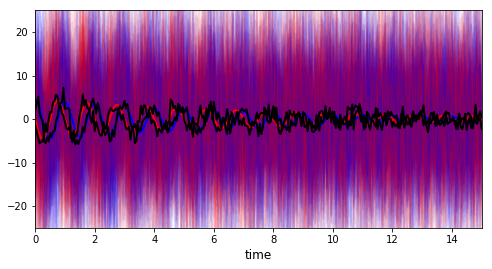

In [16]:
fig, ax = plt.subplots(figsize=(8,4))

for m in result.measurement:
    ax.plot(times, m[:, 0].real, 'b', alpha=0.05)
    ax.plot(times, m[:, 1].real, 'r', alpha=0.05)

ax.plot(times, result_ref.expect[1], 'b', lw=2);
ax.plot(times, result_ref.expect[2], 'r', lw=2);

ax.set_xlim(0, times.max())
ax.set_ylim(-25, 25)
ax.set_xlabel('time', fontsize=12)
ax.plot(times, np.array(result.measurement).mean(axis=0)[:,0].real, 'k', lw=2);
ax.plot(times, np.array(result.measurement).mean(axis=0)[:,1].real, 'k', lw=2);

## Implementation #3: builtin function for heterodyne

In [17]:
result = smesolve(H, rho0, times, [], [np.sqrt(gamma) * a],
                  e_ops, ntraj=ntraj, nsubsteps=nsubsteps, solver="taylor15",
                  method='heterodyne', store_measurement=True,
                  map_func=parallel_map)

10.0%. Run time: 102.92s. Est. time left: 00:00:15:26
20.0%. Run time: 192.86s. Est. time left: 00:00:12:51
30.0%. Run time: 294.94s. Est. time left: 00:00:11:28
40.0%. Run time: 394.82s. Est. time left: 00:00:09:52
50.0%. Run time: 496.31s. Est. time left: 00:00:08:16
60.0%. Run time: 600.57s. Est. time left: 00:00:06:40
70.0%. Run time: 696.35s. Est. time left: 00:00:04:58
80.0%. Run time: 790.93s. Est. time left: 00:00:03:17
90.0%. Run time: 889.34s. Est. time left: 00:00:01:38
100.0%. Run time: 977.49s. Est. time left: 00:00:00:00
Total run time: 977.51s


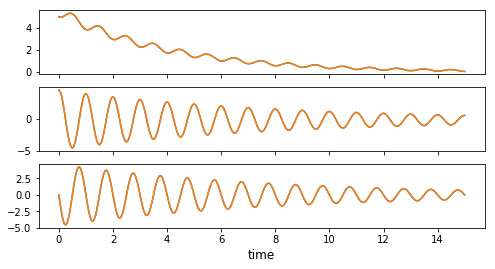

In [18]:
plot_expectation_values([result, result_ref]);

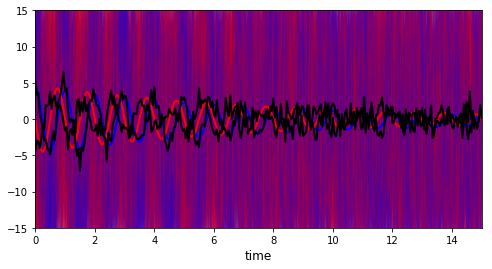

In [19]:
fig, ax = plt.subplots(figsize=(8,4))

for m in result.measurement:
    ax.plot(times, m[:, 0, 0].real / np.sqrt(gamma), 'b', alpha=0.05)
    ax.plot(times, m[:, 0, 1].real / np.sqrt(gamma), 'r', alpha=0.05)

ax.plot(times, result_ref.expect[1], 'b', lw=2);
ax.plot(times, result_ref.expect[2], 'r', lw=2);

ax.set_xlim(0, times.max())
ax.set_ylim(-15, 15)
ax.set_xlabel('time', fontsize=12)
ax.plot(times, np.array(result.measurement).mean(axis=0)[:, 0, 0].real / np.sqrt(gamma), 'k', lw=2);
ax.plot(times, np.array(result.measurement).mean(axis=0)[:, 0, 1].real / np.sqrt(gamma), 'k', lw=2);

## Common problem

For some systems, the resulting density matrix can become unphysical due to the accumulation of computation error.

In [39]:
N = 5
w0 = 1.0 * 2 * np.pi
A = 0.1 * 2 * np.pi
times = np.linspace(0, 15, 301)
gamma = 0.25

ntraj = 150
nsubsteps = 50

a = destroy(N)
x = a + a.dag()
y = -1.0j*(a - a.dag())

H = w0 * a.dag() * a + A * (a + a.dag())

rho0 = coherent(N, np.sqrt(5.0), method='analytic')
c_ops = [np.sqrt(gamma) * a]
e_ops = [a.dag() * a, x, y]

opt = Options()
opt.store_states = True
result = smesolve(H, rho0, times, [], [np.sqrt(gamma) * a],
                  e_ops, ntraj=1, nsubsteps=5, solver="euler",
                  method='heterodyne', store_measurement=True,
                  map_func=parallel_map, options=opt, normalize=False)

Total run time:   0.22s


In [40]:
result.states[0][100]

Quantum object: dims = [[5], [5]], shape = (5, 5), type = oper, isherm = True
Qobj data =
[[ 2.20745007e+00-6.23107143e-15j  5.32130593e+00+4.56698839e+00j
  -1.15619355e+01+2.17717713e+01j -4.49486710e+01-2.23074191e+01j
   2.62070369e+01-4.38589098e+01j]
 [ 5.32130593e+00-4.56698839e+00j -1.07142218e+00+7.66537134e-15j
   1.22429303e+00-2.18811629e+00j  4.44610413e+00+2.29638613e+00j
  -2.68164565e+00+4.33030355e+00j]
 [-1.15619355e+01-2.17717713e+01j  1.22429303e+00+2.18811629e+00j
  -1.72217488e-01-1.11176516e-15j -3.05912789e-01-1.58214373e-01j
   1.93781351e-01-3.02545875e-01j]
 [-4.49486710e+01+2.23074191e+01j  4.44610413e+00-2.29638613e+00j
  -3.05912789e-01+1.58214373e-01j  3.55027952e-02-3.33226863e-16j
  -1.23345523e-02+1.77468659e-02j]
 [ 2.62070369e+01+4.38589098e+01j -2.68164565e+00-4.33030355e+00j
   1.93781351e-01+3.02545875e-01j -1.23345523e-02-1.77468659e-02j
   1.20836046e-03+7.63569403e-18j]]

In [22]:
sp.linalg.eigh(result.states[0][10].full())

(array([-3.14720041e-02, -6.10858380e-05,  1.14307166e-03,  1.18849700e-02,
         3.23425775e-01]),
 array([[-0.39567109-0.j        ,  0.63456229+0.j        ,
         -0.62393366-0.j        , -0.18622189-0.j        ,
          0.12962751-0.j        ],
        [ 0.55963914-0.01726392j,  0.62575152-0.1820371j ,
          0.13269909-0.21765968j,  0.3300729 +0.16800435j,
         -0.24210188+0.03212229j],
        [-0.37291891-0.05788453j,  0.02981755-0.32786487j,
          0.36972653-0.45755152j, -0.26768387+0.56384386j,
          0.11079367+0.03599329j],
        [ 0.23987807-0.06051551j, -0.2060353 -0.09136364j,
         -0.33745337-0.15310173j, -0.50878937+0.1069029j ,
         -0.61438491-0.32081137j],
        [ 0.23004721-0.52288232j, -0.04433998+0.10714422j,
         -0.12459429+0.2164076j ,  0.07332225+0.40361154j,
          0.42487235-0.49907466j]]))

Using smaller integration steps by increasing the nsubstep will lower the numerical errors.  
The solver algorithm used affect the convergence and numerical error.
Notable solvers are:  
- euler: order 0.5 fastest, but lowest order. Only solver that accept non-commuting sc_ops
- rouchon: order 1.0?, build to keep the density matrix physical
- taylor1.5: order 1.5, default solver, reasonably fast for good convergence.
- taylor2.0: order 2.0, even better convergence but can only take 1 homodyne sc_ops.


To list list all available solver, use help(stochastic_solvers)

In [23]:
help(stochastic_solvers)

Help on function stochastic_solvers in module qutip.stochastic:

stochastic_solvers()
    Available solvers for ssesolve and smesolve
        euler-maruyama:
            A simple generalization of the Euler method for ordinary
            differential equations to stochastic differential equations.
            Only solver which could take non-commuting sc_ops. *not tested*
            -Order 0.5
            -Code: 'euler-maruyama', 'euler', 0.5
    
        milstein, Order 1.0 strong Taylor scheme:
            Better approximate numerical solution to stochastic
            differential equations.
            -Order strong 1.0
            -Code: 'milstein', 1.0
            Numerical Solution of Stochastic Differential Equations
            Chapter 10.3 Eq. (3.1), By Peter E. Kloeden, Eckhard Platen
    
        milstein-imp, Order 1.0 implicit strong Taylor scheme:
            Implicit milstein scheme for the numerical simulation of stiff
            stochastic differential equations.
 

## Versions

In [24]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.4.0.dev0+ea5344d9
Numpy,1.16.0
SciPy,1.2.0
matplotlib,3.0.2
Cython,0.29.3
Number of CPUs,1
BLAS Info,OPENBLAS
IPython,7.2.0
Python,"3.6.7 (default, Oct 22 2018, 11:32:17) [GCC 8.2.0]"
OS,posix [linux]
